In [1]:
import numpy as np
import os
from sklearn.cluster import KMeans
import json
import random
import networkx as nx
import matplotlib.pyplot as plt

np.random.seed(1)
random.seed(1)

In [2]:
import numpy as np
import sys

class CIBR(object):
    def __init__(self, dataset, n_branches, depth):
        self.dataset = dataset
        self.n_branches = n_branches
        self.depth = depth
        self.tree = {}
        self.nodes = {}
        self.leaves = {}
        
        # private:
        self._current_index = 0
    
    def extract_features(self, image=None):
        # dummy features to test
        # replace with Antonio's 
        if (image is None):
            ones = np.ones(1)
#             return np.array([ones, ones * 2, ones * 10, ones * 11])
            return np.random.randn(5000, 128)
        else:
            return sift(image)
        
    def create_tree(self, features=None, node=0, root=None, current_depth=0):
        if features is None:
            features = self.extract_features()
        if root is None:
            root = np.mean(features)
        
        self.nodes[node] = root
        
        # if `node` is a leaf node, return
        if current_depth >= self.depth or len(features) < self.n_branches:
            return
        
        # group features by cluster
        model = KMeans(n_clusters=self.n_branches)
        model.fit(features)
        children = [[] for i in range(self.n_branches)]
        for i in range(len(features)):
            children[model.labels_[i]].append(features[i])
        
        # cluster children
        self.tree[node] = []
        for i in range(self.n_branches):
            self._current_index += 1
            self.tree[node].append(self._current_index)
            self.create_tree(children[i], self._current_index, model.cluster_centers_[i], current_depth + 1, )
        return self.tree

    def create_index(self, image_path):
        points, features = self.extract_features(image_path)
        for feature in features:
            leaf = self._find_leaf_id(feature)
            if self._get_image_id(image_path) in self.leaves[leaf]:
                self.leaves[leaf][self._get_image_id(image_path)] += 1
            else:
                self.leaves[leaf][self._get_image_id(image_path)] = 1
        return

    def _get_image_id(self, image_path):
        return os.path.splitext(os.path.basename(image_path))[0]

    def _find_leaf_id(self, feature, root=0):
        """
        Returns the leaf of the tree closest to the input feature
        Args:
            feature (numpy.ndarray): The feature to lookup
            root (int): Node id to start the search from.
                        Default is 0, meaning the very root of the tree
        """
        min_dist = float("inf")
        node = None
        for child in self.tree[root]:
            distance = np.linalg.norm([self.nodes[child] - feature])  # l1 norm (or l2) 
            if distance < min_dist:
                min_dist = distance
                node = child
        return node if len(self.tree[node]) == 0 else self._find_leaf_id(feature, node)

    def encode(self, query_path):
        """
        Returns the representation of a new image using the "term frequency–inverse document frequency" (tfidf)
        Args:
            query (numpy.ndarray): image to encode
        Return:
            (numpy.ndarray): The encoded image
        """
        features = self.extract_features(query)
        image_id = self._get_image_id(query_path)
        for feature in features:
            leafID = self._find_leaf_id(feature)
            if leaf_id not in self.leaves:
                self.leaves[leafID] = {}
            if image_id in self.leaves[leaf_id]:
                self.leaves[leaf_id][image_id] += 1
            else:
                self.leaves[leaf_id][image_id] = 1

    def scores(self, query):
        """
        Scores the current query image against the images in the database
        Args:
            query (numpy.ndarray): Query image
        Returns:
            (numpy.ndarray): 
        """
        pass

In [3]:
vv3 = CIBR(None, 10, 6)
vv3.create_tree()
# print(vv3.tree)
# print(vv3.nodes)

{0: [1, 222, 503, 724, 925, 1156, 1427, 1698, 1939, 2170],
 1: [2, 23, 34, 55, 66, 87, 98, 109, 130, 181],
 2: [3, 4, 5, 6, 7, 18, 19, 20, 21, 22],
 7: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 23: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
 34: [35, 36, 37, 38, 39, 50, 51, 52, 53, 54],
 39: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 55: [56, 57, 58, 59, 60, 61, 62, 63, 64, 65],
 66: [67, 68, 69, 80, 81, 82, 83, 84, 85, 86],
 69: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
 87: [88, 89, 90, 91, 92, 93, 94, 95, 96, 97],
 98: [99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
 109: [110, 111, 112, 113, 114, 115, 116, 117, 128, 129],
 117: [118, 119, 120, 121, 122, 123, 124, 125, 126, 127],
 130: [131, 142, 153, 154, 155, 156, 157, 158, 169, 180],
 131: [132, 133, 134, 135, 136, 137, 138, 139, 140, 141],
 142: [143, 144, 145, 146, 147, 148, 149, 150, 151, 152],
 158: [159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
 169: [170, 171, 172, 173, 174, 175, 176, 177, 178, 179],
 181: [182, 183, 

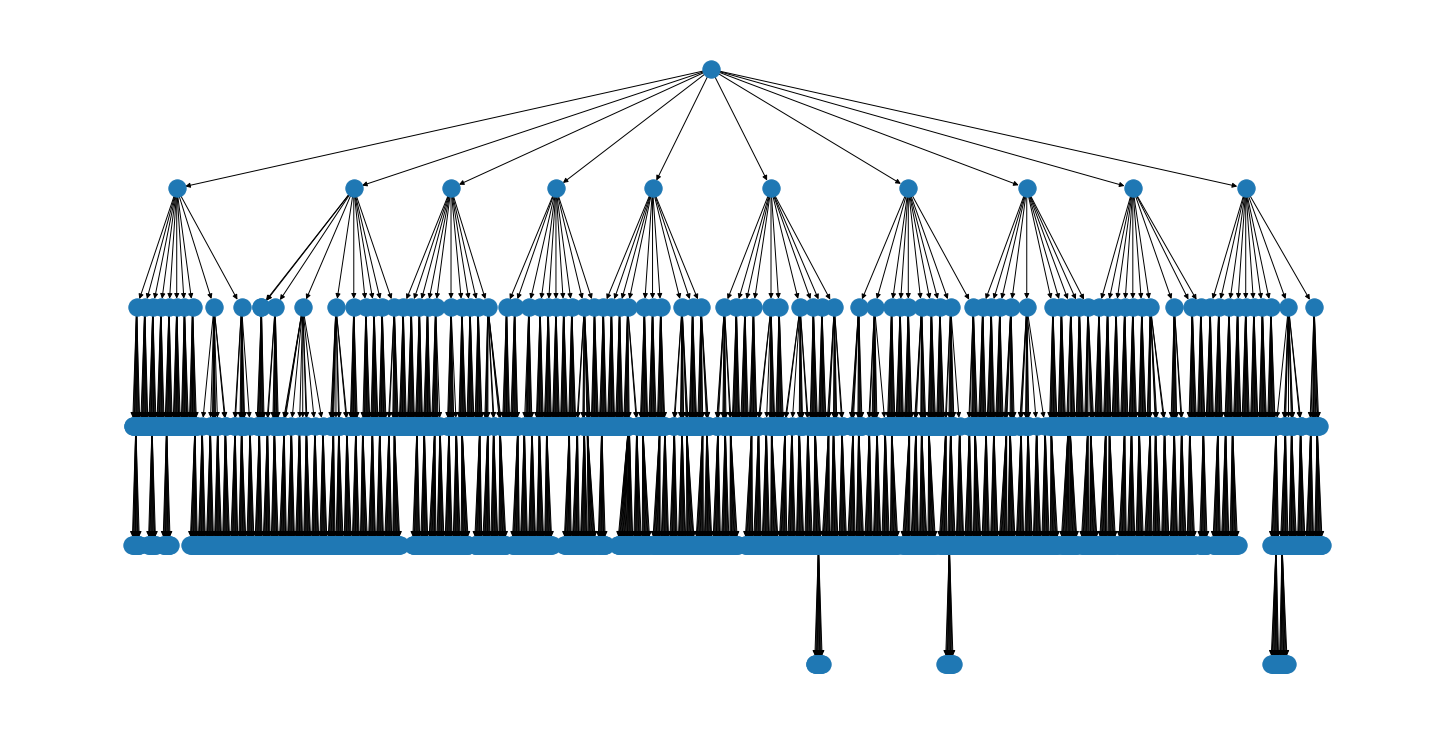

In [5]:
graph = nx.DiGraph()
for k, v in vv3.tree.items():
    graph.add_node(k)
    for link in v:
        graph.add_edge(k, link)

plt.figure(figsize=(20, 10))
pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog='dot')
nx.draw(graph, pos=pos)